In [1]:
%pip install torch


  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached MarkupSafe-3.0.2-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/212.4 MB ? eta -:--:--
    --------------------------------------- 5.2/212.4 MB 35.6 MB/s eta 0:00:06
   -- ------------------------------------- 15.5/212.4 MB 42.4 MB/s eta 0:00:05
   ---- ----------------------------------- 25.2/212.4 MB 43.1 MB/s eta 0:00:05
   ------ --------------------------------- 36.4/212.4 MB 45.4 MB/s eta 0:00:04
   -------- ------------------------------- 47.2/212.4 MB 46.2 MB/s eta 0:00:04
   ---------- ----------------------------- 54.3/212.4 MB 44.3 MB/s eta 0:00:04
   ------------ --------------------------- 64.0/212.4 MB 44.3 MB/s eta 0:00:04
   ------------- -------------------------- 73.9/212.4 MB 44.9 MB/s eta 0:00:04
   --------------- --

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Function
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

# Prep Training Data (Breast Cancer Wisconsin)
df = pd.read_csv("D:\\PHD\\FLIQ-Hackathon\\FLiQHackathon\\Datasets\\wdbc.data", header=None)
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = columns
df = df.drop(columns=['id'])
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop(columns=['diagnosis']).values.astype(np.float32)
Y = df['diagnosis'].values.astype(np.float32).reshape(-1, 1)

# Normalize (z-score)
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Train/Test split
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)
split_idx = int(num_samples * 0.8)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

X_train = X_tensor[train_indices]
Y_train = Y_tensor[train_indices]
X_test = X_tensor[test_indices]
Y_test = Y_tensor[test_indices]

# Quantum Circuit
n_qubits = 2
params = ParameterVector('theta', length=4)

def create_vqa_circuit(input_data, weights):
    qc = QuantumCircuit(n_qubits)
    
    # Encode 2 classical inputs into qubit rotations
    qc.ry(float(input_data[0]), 0)
    qc.ry(float(input_data[1]), 1)
    
    # Parameterized entangling gates
    qc.rz(weights[0], 0)
    qc.rz(weights[1], 1)
    qc.cx(0, 1)
    qc.ry(weights[2], 0)
    qc.ry(weights[3], 1)
    
    return qc

# Estimator and observable
estimator = StatevectorEstimator()
observables = [SparsePauliOp("ZI")]

# Autograd Function
class VQALayerFunction(Function):
    @staticmethod
    def forward(ctx, input_tensor, weights):
        input_vals = input_tensor.detach().numpy()
        weight_vals = weights.detach().numpy()
        ctx.save_for_backward(input_tensor, weights)

        qc = create_vqa_circuit(input_vals, weight_vals)
        job = estimator.run([(qc, observables)])
        expval = job.result()[0].data.evs[0]

        return torch.tensor([expval], dtype=torch.float32)

    @staticmethod
    def backward(ctx, grad_output):
        input_tensor, weights = ctx.saved_tensors
        input_vals = input_tensor.detach().numpy()
        weight_vals = weights.detach().numpy()
        shift = np.pi / 2
        grads = []

        for i in range(len(weight_vals)):
            shifted_plus = weight_vals.copy()
            shifted_plus[i] += shift
            shifted_minus = weight_vals.copy()
            shifted_minus[i] -= shift

            qc_plus = create_vqa_circuit(input_vals, shifted_plus)
            qc_minus = create_vqa_circuit(input_vals, shifted_minus)

            result_plus = estimator.run([(qc_plus, observables)]).result()[0].data.evs[0]
            result_minus = estimator.run([(qc_minus, observables)]).result()[0].data.evs[0]

            grad = 0.5 * (result_plus - result_minus)
            grads.append(grad)

        grads_tensor = torch.tensor(grads, dtype=torch.float32)
        return None, (grad_output.view(-1)[0] * grads_tensor).view(-1)

# PyTorch Quantum Layer
class VQALayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(4))

    def forward(self, x):
        return torch.stack([VQALayerFunction.apply(x[i], self.weights) for i in range(x.size(0))]).view(-1, 1)

# Full Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.classical = nn.Linear(X_tensor.shape[1], 2)
        self.quantum = VQALayer()
        self.output = nn.Linear(1, 1)

    def forward(self, x):
        x = self.classical(x)
        x = torch.tanh(x)
        x = self.quantum(x)
        x = self.output(x)
        return torch.sigmoid(x)

# Initialize model and training components
model = HybridModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Learning rate = [0.05, 0.02, 0.01, 0.005, 0.002, 0.001] [10^-1 to 10^-3]
loss_fn = nn.BCELoss()

# Training loop
for epoch in range(50):
    optimizer.zero_grad()
    preds = model(X_train)
    loss = loss_fn(preds, Y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        acc = ((preds > 0.5).float() == Y_train).float().mean()
        print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Accuracy: {acc.item()*100:.2f}%")

# Testing loop
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = loss_fn(test_preds, Y_test)
    test_acc = ((test_preds > 0.5).float() == Y_test).float().mean()
    print(f"\nTest Loss: {test_loss.item():.4f} | Test Accuracy: {test_acc.item()*100:.2f}%")


Epoch 1 | Loss: 0.7271 | Accuracy: 37.80%
Epoch 2 | Loss: 0.7087 | Accuracy: 37.80%
Epoch 3 | Loss: 0.6919 | Accuracy: 37.80%
Epoch 4 | Loss: 0.6765 | Accuracy: 83.30%
Epoch 5 | Loss: 0.6624 | Accuracy: 74.29%
Epoch 6 | Loss: 0.6500 | Accuracy: 66.81%
Epoch 7 | Loss: 0.6389 | Accuracy: 63.08%
Epoch 8 | Loss: 0.6291 | Accuracy: 62.20%
Epoch 9 | Loss: 0.6204 | Accuracy: 62.20%
Epoch 10 | Loss: 0.6126 | Accuracy: 62.20%
Epoch 11 | Loss: 0.6055 | Accuracy: 62.20%
Epoch 12 | Loss: 0.5990 | Accuracy: 62.20%
Epoch 13 | Loss: 0.5928 | Accuracy: 62.20%
Epoch 14 | Loss: 0.5868 | Accuracy: 62.64%
Epoch 15 | Loss: 0.5810 | Accuracy: 64.40%
Epoch 16 | Loss: 0.5754 | Accuracy: 66.81%
Epoch 17 | Loss: 0.5700 | Accuracy: 68.35%
Epoch 18 | Loss: 0.5650 | Accuracy: 70.99%
Epoch 19 | Loss: 0.5603 | Accuracy: 72.31%
Epoch 20 | Loss: 0.5560 | Accuracy: 74.07%
Epoch 21 | Loss: 0.5519 | Accuracy: 75.38%
Epoch 22 | Loss: 0.5480 | Accuracy: 77.36%
Epoch 23 | Loss: 0.5442 | Accuracy: 78.02%
Epoch 24 | Loss: 0.5

In [2]:
import sklearn.metrics as metrics

# Get predicted labels (0 or 1)
y_true = Y_test.numpy().flatten()
y_pred = (test_preds.numpy().flatten() > 0.5).astype(int)

# Metrics
accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)
conf_matrix = metrics.confusion_matrix(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# False positives and false negatives
fp = conf_matrix[0,1]
fn = conf_matrix[1,0]
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Accuracy:  0.8246
Precision: 0.7778
Recall:    0.7000
F1 Score:  0.7368
Confusion Matrix:
[[66  8]
 [12 28]]
False Positives: 8
False Negatives: 12


In [3]:
# Class distribution in the whole dataset
print("Class distribution in the dataset:")
print(df['diagnosis'].value_counts())

Class distribution in the dataset:
diagnosis
0    357
1    212
Name: count, dtype: int64


In [4]:
# Distribution of predicted labels
print("Predicted label distribution on test set:")
unique, counts = np.unique(y_pred, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

Predicted label distribution on test set:
Label 0: 78
Label 1: 36


In [5]:
# Add a synthetic gender column for demonstration
np.random.seed(42)
df['gender'] = np.random.choice(['Male', 'Female'], size=len(df))
gender_test = df['gender'].values[test_indices]

for group in np.unique(gender_test):
    idx = (gender_test == group)
    group_y_true = y_true[idx]
    group_y_pred = y_pred[idx]
    print(f"\nGroup: {group}")
    print("  Accuracy:", metrics.accuracy_score(group_y_true, group_y_pred))
    print("  Precision:", metrics.precision_score(group_y_true, group_y_pred))
    print("  Recall:", metrics.recall_score(group_y_true, group_y_pred))
    print("  F1:", metrics.f1_score(group_y_true, group_y_pred))


Group: Female
  Accuracy: 0.8125
  Precision: 0.7777777777777778
  Recall: 0.5
  F1: 0.6086956521739131

Group: Male
  Accuracy: 0.8333333333333334
  Precision: 0.7777777777777778
  Recall: 0.8076923076923077
  F1: 0.7924528301886793


In [6]:
# Attempting fairness/bias detection: Why it's not possible with WDBC

# List available columns in the dataset
print("Available columns in the dataset:")
print(df.columns.tolist())

# Check for presence of sensitive attributes
sensitive_attributes = ['gender', 'age', 'race', 'ethnicity']
present_sensitive = [attr for attr in sensitive_attributes if attr in df.columns]

if not present_sensitive:
    print("\nNo sensitive demographic attributes (e.g., gender, age, race) are present in the dataset.")
    print("=> True fairness and bias detection across demographic groups is NOT possible.")
else:
    print("\nSensitive attributes found:", present_sensitive)
    print("You can perform group fairness analysis using these attributes.")

Available columns in the dataset:
['diagnosis', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'gender']

Sensitive attributes found: ['gender']
You can perform group fairness analysis using these attributes.


In [7]:
# --- Fairness & Bias Detection: Why it's not possible with WDBC ---

print("Available columns in the dataset:")
print(df.columns.tolist())

# Check for demographic attributes
demographic_columns = ['gender', 'age', 'race', 'ethnicity']
found = [col for col in demographic_columns if col in df.columns]

if not found:
    print("\nNo real demographic attributes (e.g., gender, age, race) are present in the dataset.")
    print("=> True demographic fairness analysis (e.g., Disparate Impact Ratio) is NOT possible.")
else:
    print("\nDemographic columns found:", found)
    print("You can perform fairness analysis using these columns.")

# --- Synthetic Example for Demonstration Only ---
print("\nDemonstrating with a synthetic 'gender' attribute (not real):")

# Add a synthetic gender column
np.random.seed(42)
df['gender'] = np.random.choice(['Male', 'Female'], size=len(df))
gender_test = df['gender'].values[test_indices]

# Calculate Disparate Impact Ratio (DIR) for positive predictions
# DIR = (Pr[positive | group=Female]) / (Pr[positive | group=Male])
female_idx = (gender_test == 'Female')
male_idx = (gender_test == 'Male')
pr_female = y_pred[female_idx].mean()
pr_male = y_pred[male_idx].mean()
dir_value = pr_female / pr_male if pr_male > 0 else np.nan

print(f"Positive prediction rate (Female): {pr_female:.3f}")
print(f"Positive prediction rate (Male):   {pr_male:.3f}")
print(f"Disparate Impact Ratio (DIR):      {dir_value:.3f}")

print("\nNOTE: This is only a demonstration. The 'gender' attribute is synthetic and does not reflect real demographic fairness.")

Available columns in the dataset:
['diagnosis', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'gender']

Demographic columns found: ['gender']
You can perform fairness analysis using these columns.

Demonstrating with a synthetic 'gender' attribute (not real):
Positive prediction rate (Female): 0.188
Positive prediction rate (Male):   0.409
Disparate Impact Ratio (DIR):      0.458

NOTE: This is only a demonstration. The 'gender' attribute is synthetic and does not reflect real demographic fairness.


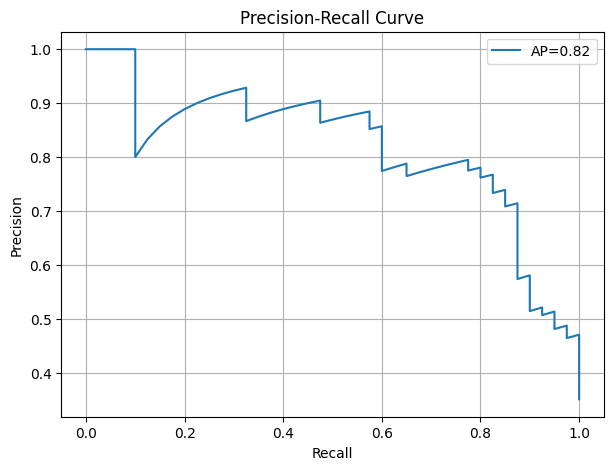

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities (not just hard labels)
y_scores = test_preds.numpy().flatten()

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

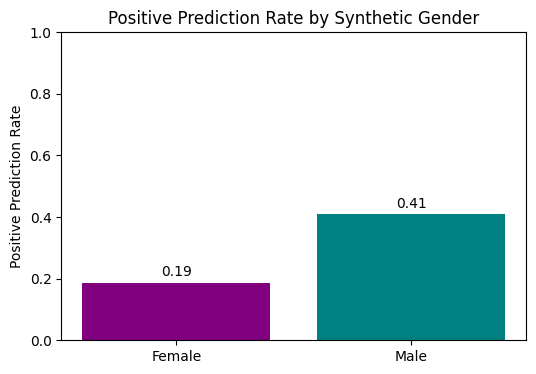

Disparate Impact Ratio (DIR): 0.458


In [9]:
groups = ['Female', 'Male']
rates = [pr_female, pr_male]

plt.figure(figsize=(6,4))
plt.bar(groups, rates, color=['purple', 'teal'])
plt.ylabel('Positive Prediction Rate')
plt.title('Positive Prediction Rate by Synthetic Gender')
plt.ylim(0, 1)
for i, v in enumerate(rates):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

print(f"Disparate Impact Ratio (DIR): {dir_value:.3f}")

Summary:

The first plot shows the overall precision-recall tradeoff.
The second plot visualizes group fairness (synthetic) by showing positive prediction rates for each group and the DIR.